# Previsão de Aprovação de Emprestéstimos é Adequado

O objetivo é claro: prever a variável binária Loan_Status (Aprovado ou Rejeitado). Isto é um problema de classificação ideal para treinar modelos como Random Forest, Regressão Logística ou SVM e analisar as suas métricas de forma aprofundada.

## Dataset

O dataset elegido para este estudo foi **"Realistic Loan Approval Dataset | US & Canada""**, que contém características (features) que são cruciais no mundo real para a decisão de crédito, como:

cibil_score (Credit Score): O atributo mais preditivo para crédito.

income_annum: Rendimento Anual.

loan_amount: Valor do Empréstimo.

Atributos de Risco: no_of_dependents, loan_term, valor dos ativos.

### Necessário

> dataset : Loan_approval_data_2025.csv.
>
> obtido em : https://www.kaggle.com/datasets/parthpatel2130/realistic-loan-approval-dataset-us-and-canada

In [131]:
!pip install mlxtend
!pip install catboost
!pip install xgboost
import pandas as pd
import numpy as np

from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from mlxtend.frequent_patterns import apriori, association_rules

import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

import joblib

plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['figure.dpi'] = 120


   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   - -------------------------------------- 1.8/72.0 MB 12.6 MB/s eta 0:00:06
   -- ------------------------------------- 4.5/72.0 MB 12.2 MB/s eta 0:00:06
   --- ------------------------------------ 6.8/72.0 MB 11.7 MB/s eta 0:00:06
   ----- ---------------------------------- 9.7/72.0 MB 11.8 MB/s eta 0:00:06
   ------ --------------------------------- 12.6/72.0 MB 12.1 MB/s eta 0:00:05
   -------- ------------------------------- 15.2/72.0 MB 12.1 MB/s eta 0:00:05
   --------- ------------------------------ 17.8/72.0 MB 12.5 MB/s eta 0:00:05
   ----------- ---------------------------- 20.7/72.0 MB 12.5 MB/s eta 0:00:05
   ------------- -------------------------- 24.4/72.0 MB 13.1 MB/s eta 0:00:04
   --------------- ------------------------ 28.6/72.0 MB 13.8 MB/s eta 0:00:04
   ------------------ --------------------- 32.8/72.0 MB 14.4 MB/s eta 0:00:03
   -------------------- ------------------- 37.2/72.0 MB 15.1 MB/

# Limpeza Do Dataset

Iremos limpar o dataset



In [112]:
data_set_path = "./Data/Loan_approval_data_2025.csv"
df = pd.read_csv(data_set_path)
display(df.head())

# Debbug Extra
#print(df.columns)
#print(df.shape)
#print(df.info()) 

,customer_id,age,occupation_status,years_employed,annual_income,credit_score,credit_history_years,savings_assets,current_debt,defaults_on_file,delinquencies_last_2yrs,derogatory_marks,product_type,loan_intent,loan_amount,interest_rate,debt_to_income_ratio,loan_to_income_ratio,payment_to_income_ratio,loan_status
0,CUST100000,40,Employed,17.2,25579,692,5.3,895,10820,0,0,0,Credit Card,Business,600,17.02,0.423,0.023,0.008,1
1,CUST100001,33,Employed,7.3,43087,627,3.5,169,16550,0,1,0,Personal Loan,Home Improvement,53300,14.10,0.384,1.237,0.412,0
2,CUST100002,42,Student,1.1,20840,689,8.4,17,7852,0,0,0,Credit Card,Debt Consolidation,2100,18.33,0.377,0.101,0.034,1
3,CUST100003,53,Student,0.5,29147,692,9.8,1480,11603,0,1,0,Credit Card,Business,2900,18.74,0.398,0.099,0.033,1
4,CUST100004,32,Employed,12.5,63657,630,7.2,209,12424,0,0,0,Personal Loan,Education,99600,13.92,0.195,1.565,0.522,1


In [51]:
cols_to_delete = ["customer_id"]
df_without_id =df.drop(columns = cols_to_delete)

# Verificação rápida para vermos se temos valor em falta
missing_values = df_without_id.isna().sum()
print(missing_values)


age                        0
occupation_status          0
years_employed             0
annual_income              0
credit_score               0
credit_history_years       0
savings_assets             0
current_debt               0
defaults_on_file           0
delinquencies_last_2yrs    0
derogatory_marks           0
product_type               0
loan_intent                0
loan_amount                0
interest_rate              0
debt_to_income_ratio       0
loan_to_income_ratio       0
payment_to_income_ratio    0
loan_status                0
dtype: int64


### One-Hot Enconding

No dataset originial as váriveis product_type e loan_intent possuem valores em string, de forma a preparar os dados para machine learning devemos padronizar a informação. Neste caso usamos o One-Hot Enconding que é mais seguro uma vez que estas veriávies nao têm uma ordem inerente.

Desta forma, as três colunas originais de texto `occupation_status, product_type, loan_intent` foram substituídas por várias novas colunas binárias (True ou False, que o modelo de ML trata como $1$ ou $0$).

In [116]:
categorical_cols = ['occupation_status', 'product_type', 'loan_intent']

df_new = pd.get_dummies(df_without_id , columns = categorical_cols, drop_first = True)
display(df_new.head())

,age,years_employed,annual_income,credit_score,credit_history_years,savings_assets,current_debt,defaults_on_file,delinquencies_last_2yrs,derogatory_marks,...,loan_status,occupation_status_Self-Employed,occupation_status_Student,product_type_Line of Credit,product_type_Personal Loan,loan_intent_Debt Consolidation,loan_intent_Education,loan_intent_Home Improvement,loan_intent_Medical,loan_intent_Personal
0,40,17.2,25579,692,5.3,895,10820,0,0,0,...,1,False,False,False,False,False,False,False,False,False
1,33,7.3,43087,627,3.5,169,16550,0,1,0,...,0,False,False,False,True,False,False,True,False,False
2,42,1.1,20840,689,8.4,17,7852,0,0,0,...,1,False,True,False,False,True,False,False,False,False
3,53,0.5,29147,692,9.8,1480,11603,0,1,0,...,1,False,True,False,False,False,False,False,False,False
4,32,12.5,63657,630,7.2,209,12424,0,0,0,...,1,False,False,False,True,False,True,False,False,False


## Normalização

As colunas numéricas foram normalizadas com o StandardScaler(), que ajusta os dados para média zero e desvio padrão igual a um. Esta etapa é importante para algoritmos sensíveis a escalas, como clustering, PCA e métodos baseados em distância.

Usamos o StandardScaler, para transformar os dados para estes terem a médica de 0 e um desvio padrão de 1. Assim indentificamos as colunas que devemos escalonar, estas estão contidas no `array -> numeric_cols`


In [63]:
numeric_cols = [
    'age', 'years_employed', 'annual_income', 'credit_score', 
    'credit_history_years', 'savings_assets', 'current_debt', 
    'loan_amount', 'interest_rate', 'debt_to_income_ratio', 
    'loan_to_income_ratio', 'payment_to_income_ratio'
]

scaler = StandardScaler()

df_new[numeric_cols] = scaler.fit_transform(df_new[numeric_cols])

#Debbug
print("\nDataFrame após Escalonamento:\n", df_new.head())


DataFrame após Escalonamento:
         age  years_employed  annual_income  credit_score  \
0  0.453563        1.280229      -0.750345      0.747482   
1 -0.176018       -0.020345      -0.213787     -0.256675   
2  0.633444       -0.834846      -0.895579      0.701137   
3  1.622787       -0.913669      -0.640998      0.747482   
4 -0.265959        0.662785       0.416612     -0.210330   

   credit_history_years  savings_assets  current_debt  defaults_on_file  \
0             -0.397958       -0.204093     -0.262046                 0   
1             -0.647698       -0.258959      0.170615                 0   
2              0.032151       -0.270446     -0.486154                 0   
3              0.226393       -0.159883     -0.202923                 0   
4             -0.134343       -0.255936     -0.140931                 0   

   delinquencies_last_2yrs  derogatory_marks  ...  loan_status  \
0                        0                 0  ...            1   
1                       

## Preparação para o Treino e Avaliação do Modelo

Vamos separar os dados de treino e de teste, 70% do dataset será de treino e o restante de teste

> `X - Features,` serao todas as colunas que o modelo usará para fazer a previsão
> 
> `y - Target`, a variável que queremos prever, no caso loan_status

In [118]:

X = df_new.drop('loan_status', axis=1)
y = df_new['loan_status']


X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = 0.30, # 30%
    random_state = 42,
    stratify=y # Garante a propoção
)

# Debugg
print(f"Número de Features (X): {X.shape[1]}")
print(f"Número de Observações (y): {y.shape[0]}")
print("-" * 30)
print(f"X_train (Treino): {X_train.shape}")
print(f"X_test (Teste):   {X_test.shape}")
print("-" * 30)

Número de Features (X): 24
Número de Observações (y): 50000
------------------------------
X_train (Treino): (35000, 24)
X_test (Teste):   (15000, 24)
------------------------------


## Treinamento do Modelo

Para treinamos o modelo iremos exprimentar sobre vários modelos

> `Decision Tree` - Tende a ser instável e propenso a overfitting nos dados de treino
>
> `Random Forest Classifier` - Modelo de ensemble. Combina centenas de Árvores de Decisão independentes e usa o voto maioritário para a previsão final
>
> `Regressão Logística` - Mode Linear simples. Tem a desvantagem de não conseguir capturar relações não lineares complexas, como o credict_score, annual_income e loan_status
> 

In [152]:
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=50000), # Valor alto para o modelo poder esta a vontade
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'CatBoost': CatBoostClassifier( verbose=0, random_state=42, allow_writing_files=False)
}

results = {}

print('Inicio do Treinamento')

for name, model in models.items():
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    conf_mat = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, zero_division=0)
    acc = accuracy_score(y_test, y_pred)

    results[name] = {
        'Accuracy': acc,
        'Confusion Matrix': conf_mat,
        'Classification Report': class_report
    }

    print(f"\n {name} Concluído. Precisão: {acc: .4f}")


Inicio do Treinamento

 Decision Tree Concluído. Precisão:  0.8712

 Random Forest Concluído. Precisão:  0.9124


C:\Users\vasco\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\vasco\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [23:24:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 Logistic Regression Concluído. Precisão:  0.8585

 XGBoost Concluído. Precisão:  0.9251

 CatBoost Concluído. Precisão:  0.9313


**Erro nas iterções** : Apesar do valor alto `max_iter` estar em 50 000 iterações o erro de convergência existe, significando que a natureza dos dados é fortemente, não linear, o que dificulta um modelo linear simples de convergir, no entanto em relação a testes anteriores com um valor de 1000 para 50 000 interção ganhamos cerca de 5% de melhorias no valor da precisão

### Apresentação das Matrizes Confusão

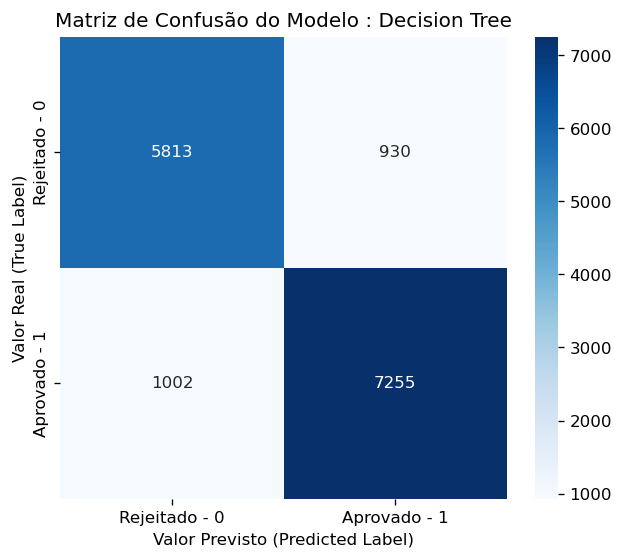

--------------------------------------------------
Resultados para Decision Tree:
FP (Risco: Aprovou mau cliente): 930
FN (Perda: Rejeitou bom cliente): 1002


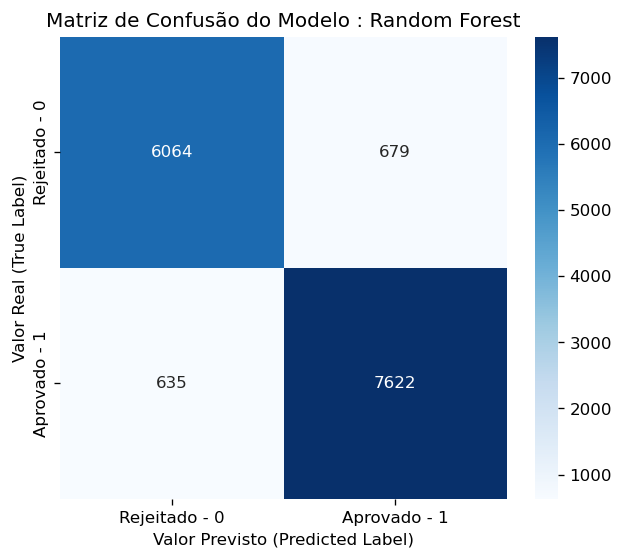

--------------------------------------------------
Resultados para Random Forest:
FP (Risco: Aprovou mau cliente): 679
FN (Perda: Rejeitou bom cliente): 635


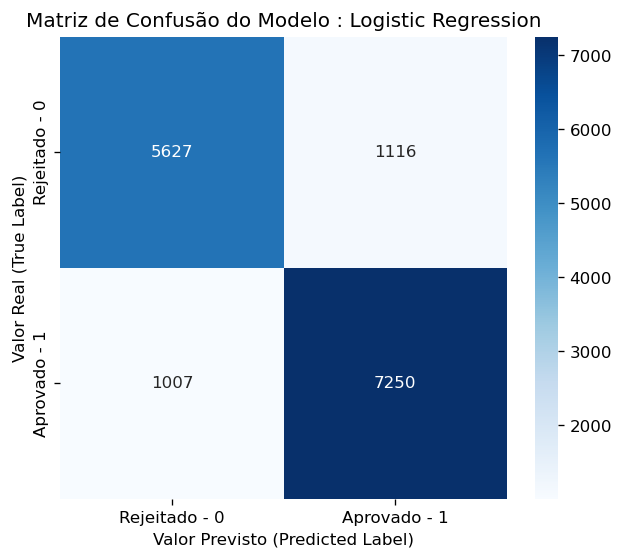

--------------------------------------------------
Resultados para Logistic Regression:
FP (Risco: Aprovou mau cliente): 1116
FN (Perda: Rejeitou bom cliente): 1007


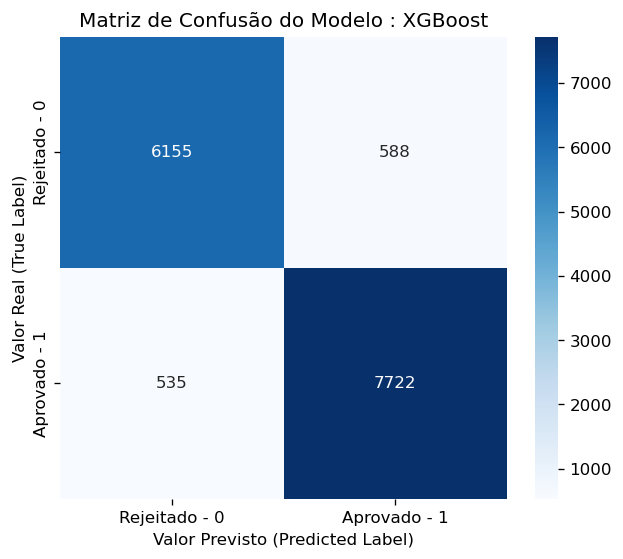

--------------------------------------------------
Resultados para XGBoost:
FP (Risco: Aprovou mau cliente): 588
FN (Perda: Rejeitou bom cliente): 535


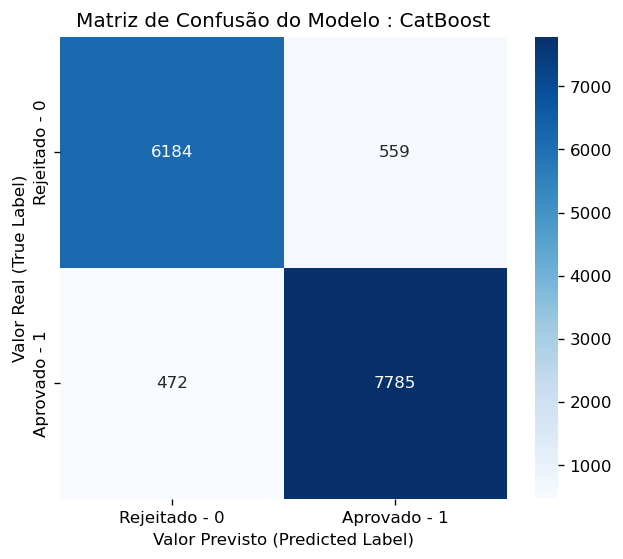

--------------------------------------------------
Resultados para CatBoost:
FP (Risco: Aprovou mau cliente): 559
FN (Perda: Rejeitou bom cliente): 472


In [153]:
labels = ['Rejeitado - 0', 'Aprovado - 1']

def plot_confusion_matrix(cm, model_name):
    """ Apresenta as matrizes confusão, num heatmap """

    plt.figure(figsize=(6,5))

    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d',          # Formata os números como inteiros
        cmap='Blues',     # Escolhe um esquema de cores
        xticklabels=labels, 
        yticklabels=labels
    )

    plt.title(f'Matriz de Confusão do Modelo : {model_name}')
    plt.ylabel('Valor Real (True Label)')
    plt.xlabel('Valor Previsto (Predicted Label)')
    plt.show()

for name, res in results.items():
    cm = res['Confusion Matrix']
    plot_confusion_matrix(cm, name)

    tn, fp, fn, tp = cm.ravel()
    
    print("-" * 50)
    print(f"Resultados para {name}:")
    print(f"FP (Risco: Aprovou mau cliente): {fp}")
    print(f"FN (Perda: Rejeitou bom cliente): {fn}")

#### Interpetação

As matrizes de confusão mostram qual o modelo que atinge o equilíbrio ideal entre a maior precisão e a melhor gestão de risco, minimizando os erros mais dispendiosos no contexto de um empréstimo.

O modelo CatBoost provou ser o mais robusto e eficaz, superando o Random Forest em todas as métricas críticas de gestão de risco.

**Em suma**, em suma este modelo, demostrou uma superioridade significativa sobre os outros modelos, para além de apresentar uma precisão de ~93.13%.

- Com 559 Falsos positivos, é o modelo que menos vezes aprova um cliente que realmente deveria ter sido rejeitado. Em contexto bancário, este erro traz mais prejuizos para a entidade bancária, pois leva a um prejuizo real.
    
- Um FN, com 472 Falsos Negativos, é também o modelo que menos rejeita um cliente que realmente deveria ter sido aprovado, consequentemente dando à origem de uma perda de oportunidade de gerar **lucro**

# Importância das Variáveis

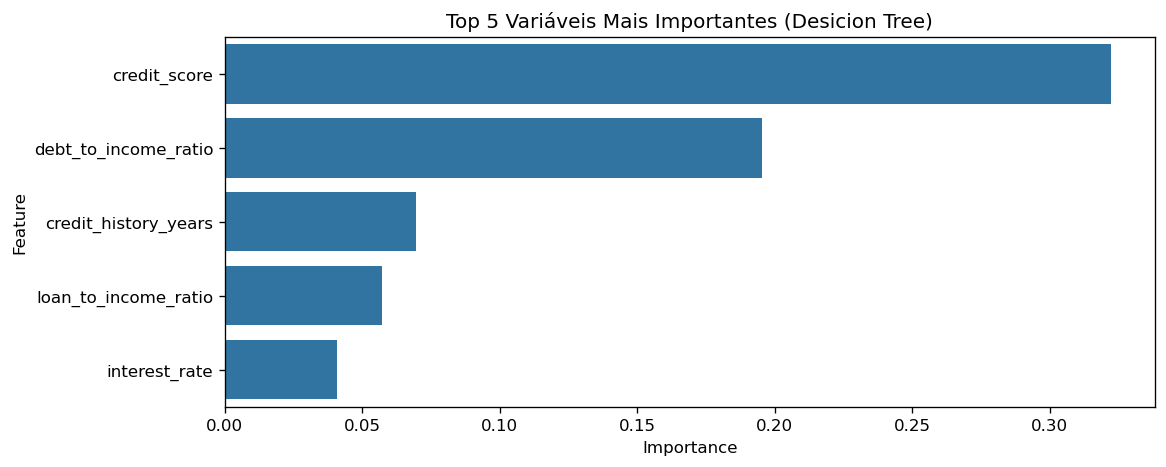

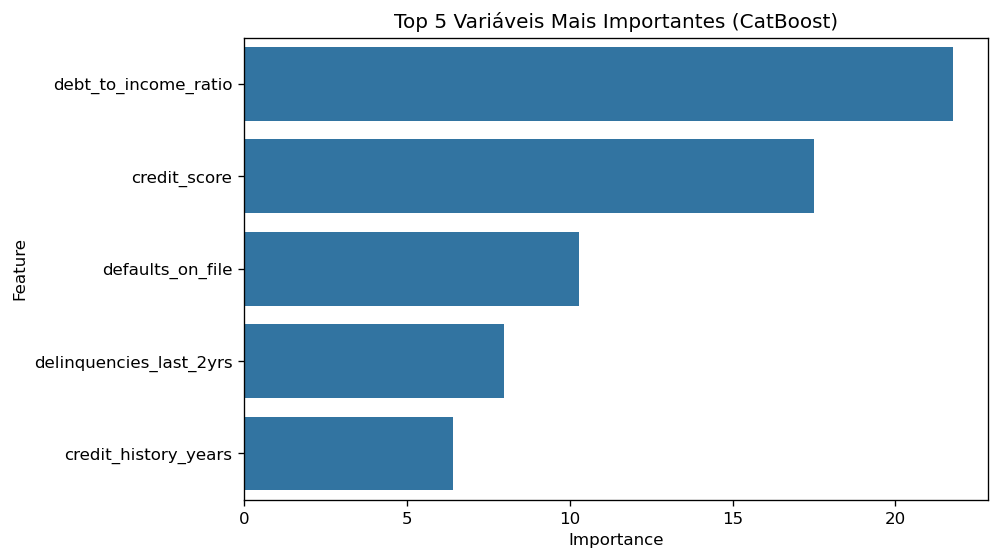


--- Top 10 Variáveis Mais Importantes ---
                    Feature  Importance
12     debt_to_income_ratio   21.755028
3              credit_score   17.488390
7          defaults_on_file   10.279326
8   delinquencies_last_2yrs    7.985758
4      credit_history_years    6.429697


In [168]:
model_rf = models['CatBoost']
model_rf_dt = models['Decision Tree']

importances = model_rf.feature_importances_
importancesDt = model_rf_dt.feature_importances_

feature_names = X_train.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

feature_names_dt = X_train.columns
feature_importance_df_dt = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importancesDt
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df_dt = feature_importance_df_dt.sort_values(by='Importance', ascending=False)

top_n = 5
plt.figure(figsize=(10,4))

sns.barplot(
    x='Importance',
    y='Feature',
    data=feature_importance_df_dt.head(top_n)
)

plt.title(f'Top {top_n} Variáveis Mais Importantes (Desicion Tree)')
plt.show()


sns.barplot(
    x='Importance',
    y='Feature',
    data=feature_importance_df.head(top_n)
)

plt.title(f'Top {top_n} Variáveis Mais Importantes (CatBoost)')
plt.show()

print("\n--- Top 10 Variáveis Mais Importantes ---")
print(feature_importance_df.head(top_n))


#### Interpretação

Comparando o grafico de importâncias do melhor modelo registado - CatBost e um dos piores - DesicionTree é notável que o algoritmo não usou as mesmas variáveis, isto deve-se à diferença estrutural 

> - O Decision tree é um algoritmo greedy, constroi uma unica arvore e seleciona o split que melhor separa os dados em cada nó de cima para baixo.
>
> - Catboost, é um algoritmo de ensemble, ou seja Bosting. Constroi milheres de árvores sequencialmente, cada uma corrige os erros cometidos pelos conjunto anterior.
>

> Assim o peso das variáveis em cada algoritmo é diferente, num algoritmo greddy a frequência e eficácia com que uma variável é usadanos splits próximos do topo da árvore, já nos algoritmos de ensemble o peso a cada variável é dado pela contribuição média de uma vriável na redução do erro ao longo de todas as milhares de árvores. O modelo procura features que as árvores anteriores não conseguiram capturar.


Esta análise de importância de features valida o modelo CatBoost, onde o modelo está a tomar decisões de aprovação com base em fatores economicamente e financeiramente relevantes, em vez de depender de correlações espúrias.

A análise confirma que o Risco - medido por credit_score, debt_to_income_ratio e histórico é o motor principal da decisão de aprovação no seu dataset.